<a href="https://colab.research.google.com/github/sayantann7/football-analyzer/blob/main/International_Football_Analyzer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Google Colab Notebook for Football Analysis

## Packages Installation

In [1]:
!pip install -q kagglehub pandas matplotlib seaborn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

print("Libraries installed and imported.")

Libraries installed and imported.


##Downloading Kaggle Dataset

In [27]:
# from google.colab import files
# files.upload()
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/  # This copies your uploaded kaggle.json to the right folder
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d martj42/international-football-results-from-1872-to-2017 --unzip

!ls -lh

Dataset URL: https://www.kaggle.com/datasets/martj42/international-football-results-from-1872-to-2017
License(s): CC0-1.0
total 6.4M
-rw-r--r-- 1 root root 1.4K Mar 21 18:13 former_names.csv
-rw-r--r-- 1 root root 2.9M Mar 21 18:13 goalscorers.csv
-rw-r--r-- 1 root root   66 Mar 21 18:02 kaggle.json
-rw-r--r-- 1 root root 3.5M Mar 21 18:13 results.csv
drwxr-xr-x 1 root root 4.0K Mar 20 13:31 sample_data
-rw-r--r-- 1 root root  28K Mar 21 18:13 shootouts.csv


## Loading CSV Data

In [29]:
csv_file = "results.csv"
df = pd.read_csv(csv_file)
print(f"Original dataset shape: {df.shape}")

Original dataset shape: (47980, 9)


##Elo Rating System For Finding Top 10 Teams

In [30]:
# We will compute Elo ratings through all matches (in chronological order),
# then filter for teams with more than 800 matches, and also record rating evolution.

default_rating = 1500        # Starting Elo rating for each team
K = 20                       # Elo sensitivity factor
home_advantage = 50          # Home advantage (points)

elo_ratings = {}           # Final rating per team
games_played = {}          # Total matches played per team
# To track rating evolution over time, record each update with the date.
rating_history = {}

import math

# Sort the DataFrame by date
df_sorted = df.sort_values('date')

for idx, row in df_sorted.iterrows():
    home_team = row['home_team']
    away_team = row['away_team']
    home_score = row['home_score']
    away_score = row['away_score']
    match_date = row['date']

    # Determine outcomes (1=win, 0=loss, 0.5=draw)
    if home_score > away_score:
        outcome_home = 1.0
        outcome_away = 0.0
    elif home_score < away_score:
        outcome_home = 0.0
        outcome_away = 1.0
    else:
        outcome_home = outcome_away = 0.5

    # Initialize ratings and history if not present
    for team in [home_team, away_team]:
        if team not in elo_ratings:
            elo_ratings[team] = default_rating
            games_played[team] = 0
            rating_history[team] = []

    R_home = elo_ratings[home_team]
    R_away = elo_ratings[away_team]
    # Add home advantage
    R_home_eff = R_home + home_advantage

    # Expected scores
    E_home = 1 / (1 + math.pow(10, (R_away - R_home_eff) / 400))
    E_away = 1 / (1 + math.pow(10, (R_home_eff - R_away) / 400))

    # Update ratings
    new_R_home = R_home + K * (outcome_home - E_home)
    new_R_away = R_away + K * (outcome_away - E_away)
    elo_ratings[home_team] = new_R_home
    elo_ratings[away_team] = new_R_away

    # Update games played
    games_played[home_team] += 1
    games_played[away_team] += 1

    # Record rating history with date
    rating_history[home_team].append((match_date, new_R_home))
    rating_history[away_team].append((match_date, new_R_away))

# Build a DataFrame with final ratings, filtering teams with >800 matches.
elo_df = pd.DataFrame([
    {"TEAM": team, "RATING": rating, "TOTAL MATCHES": games_played[team]}
    for team, rating in elo_ratings.items()
])
elo_df = elo_df[elo_df['TOTAL MATCHES'] > 800]
elo_df = elo_df.sort_values("RATING", ascending=False)

print("Top 10 teams by Elo rating :")
print(elo_df.head(10))

Top 10 teams by Elo rating :
           TEAM       RATING  TOTAL MATCHES
7     Argentina  1970.274560           1053
32       Brazil  1930.299282           1045
12       France  1928.325969            918
1       England  1882.630235           1076
23        Italy  1867.810535            873
20      Germany  1860.060783           1014
17  Netherlands  1851.050233            857
6       Uruguay  1847.544593            954
11      Belgium  1830.572710            836
29      Denmark  1790.206314            856


##Plot Elo Rating Evolution for Top 3 Teams

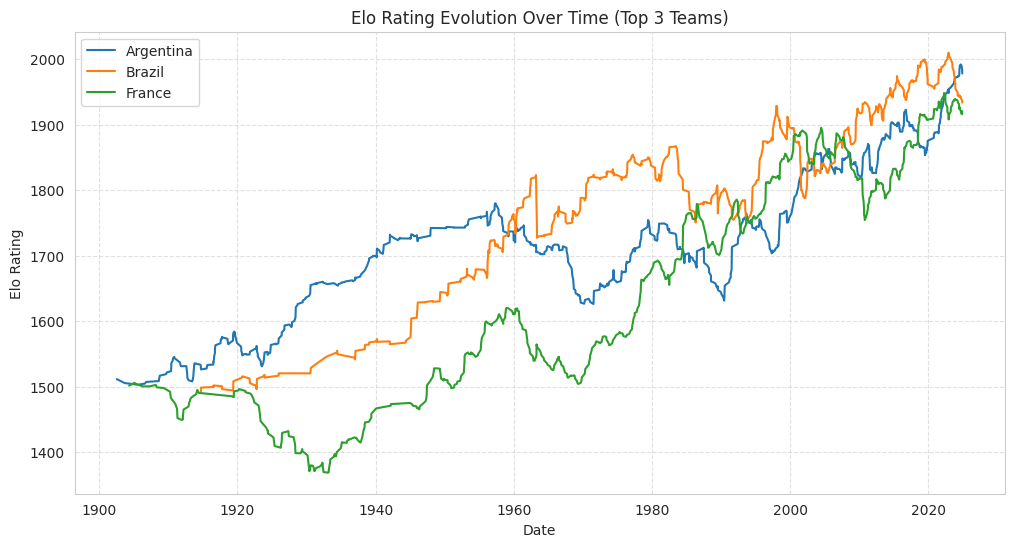

In [43]:
selected_teams = elo_df.sort_values(by='RATING', ascending=False).head(3)['TEAM'].tolist()

plt.figure(figsize=(12, 6))

for team in selected_teams:
    hist = rating_history[team]
    if hist:
        hist_df = pd.DataFrame(hist, columns=['date', 'RATING'])
        hist_df['date'] = pd.to_datetime(hist_df['date'])
        hist_df = hist_df.sort_values(by='date')
        hist_df['RATING_SMOOTH'] = hist_df['RATING'].rolling(window=5, min_periods=1).mean()
        plt.plot(hist_df['date'], hist_df['RATING_SMOOTH'], label=team)

plt.title("Elo Rating Evolution Over Time (Top 3 Teams)")
plt.xlabel("Date")
plt.ylabel("Elo Rating")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

##Which teams like to play each other

In [38]:
matchups = df.groupby(['home_team','away_team']).size().reset_index(name='count')
matchups = matchups.sort_values('count', ascending=False)
matchups.head(10)  # top 10 most frequent pairings

,home_team,away_team,count
455,Argentina,Uruguay,99
11387,Uruguay,Argentina,83
658,Austria,Hungary,69
4704,Hungary,Austria,68
5781,Kenya,Uganda,66
437,Argentina,Paraguay,65
7415,Netherlands,Belgium,64
1071,Belgium,Netherlands,64
1445,Brazil,Paraguay,60
5586,Jersey,Guernsey,60


##Which countries host the most matches where they themselves are not participating

In [39]:
df['host_is_not_playing'] = ~((df['country'] == df['home_team']) | (df['country'] == df['away_team']))

host_counts = df[df['host_is_not_playing']].groupby('country').size().reset_index(name='matches_hosted_without_playing')
host_counts = host_counts.sort_values('matches_hosted_without_playing', ascending=False)

print("Top 10 countries that host the most matches they do not participate in:")
host_counts.head(10)

Top 10 countries that host the most matches they do not participate in:


,country,matches_hosted_without_playing
221,United States,961
125,Malaysia,508
70,France,440
168,Qatar,429
210,Thailand,361
191,South Africa,353
219,United Arab Emirates,342
63,England,267
196,Spain,249
77,Germany,224
